## Implemention of K-means Clustering and Vectorization


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


### Deep dive into the dataset

In [5]:
df = pd.read_csv("../data/sample.csv", sep=";")
df.head()

,from,to,cc,subject,date,body
0,kay.mann@enron.com,"mscolo@poynerspruill.com, kraber@electricities...","heather.kroll@enron.com, ozzie.pagan@enron.com...",Revised option agreement,"Thu, 27 Jul 2000 06:15:00 -0700 (PDT)","Gentlemen,\n\nI have made the revisions to par..."
1,kam.keiser@enron.com,stacey.richardson@enron.com,NaN,FW: New List of Financial Natural Gas Terminat...,"Wed, 19 Dec 2001 07:38:14 -0800 (PST)",This what she sent.\n\nThanks\n\nKam\n\n\n ---...
2,schwabalerts.marketupdates@schwab.com,jeff.dasovich@enron.com,NaN,"Midday Market View for June 5, 2001","Tue, 5 Jun 2001 04:38:00 -0700 (PDT)","Charles Schwab & Co., Inc.\n\nMidday Market Vi..."
3,cheryl.nelson@enron.com,"sara.shackleton@enron.com, mark.taylor@enron.com",NaN,Unenforceable Arbitration Clauses in Brokerage...,"Mon, 12 Mar 2001 04:38:00 -0800 (PST)",I completed research confirming that certain p...
4,jane.wilson@enron.com,NaN,NaN,Accomplishments,"Mon, 10 Jul 2000 06:34:00 -0700 (PDT)",SK - I've printed this out and have it in a fo...


In [6]:
df.shape

(51740, 6)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51740 entries, 0 to 51739
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   from     51740 non-null  object
 1   to       49545 non-null  object
 2   cc       12779 non-null  object
 3   subject  49848 non-null  object
 4   date     51740 non-null  object
 5   body     51740 non-null  object
dtypes: object(6)
memory usage: 2.4+ MB


#### Data Cleaning

Convert date column to datetime

```python

In [14]:
df['date'] = df['date'].astype('str')
df['date'] = df['date'].str.split('-').str[0]
df['date'] = pd.to_datetime(df['date'])
df.dtypes

date    datetime64[ns]
body            object
dtype: object

In [16]:
df.head()

,date,body
0,2000-01-01,"Gentlemen,\n\nI have made the revisions to par..."
1,2001-01-01,This what she sent.\n\nThanks\n\nKam\n\n\n ---...
2,2001-01-01,"Charles Schwab & Co., Inc.\n\nMidday Market Vi..."
3,2001-01-01,I completed research confirming that certain p...
4,2000-01-01,SK - I've printed this out and have it in a fo...


In [9]:
df.drop(['from', 'to', 'cc', 'subject'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51740 entries, 0 to 51739
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    51740 non-null  object
 1   body    51740 non-null  object
dtypes: object(2)
memory usage: 808.6+ KB


In [19]:
df = df.sort_values(by='date')
df = df.reset_index(drop=True)

df = df.loc[df['body'].notnull()]

df.loc[df['body'].notnull()].shape

df.isnull().sum()

df = df.reset_index(drop=True)




date    0
body    0
dtype: int64

### K-means Clustering

```python

In [21]:
# Importing the libraries

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.feature_extraction import _stop_words
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [38]:
stopwords = ENGLISH_STOP_WORDS
my_stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient', 'sent', 'enron', 'cc', 'subject',\
                                         'forwarded', 'corp', 'said', 'attached', 'ect',\
                                         'recipient', 'email', 'original', 'doc', 'pm', 'mail', 'message', 'new'\
                                         'enronxgate', 'na', 'year'])

cv = CountVectorizer(analyzer='word', stop_words=my_stopwords, max_features=2000)
X = cv.fit_transform(df['body'])

pd.set_option('display.max_columns', 500)


X_df = pd.DataFrame(X.toarray(), columns=cv.get_feature_names())

X_df.shape

C:\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(51740, 2000)

In [39]:
X_df.head(1)

,00,000,00pm,01,018,02,03,04,05,06,07,08,09,0f,0pt,10,100,11,12,13,14,1400,15,150,16,160,17,18,19,1998,1999,1st,20,200,2000,2001,2002,202,21,212,22,23,24,25,250,26,27,28,281,29,2ecom,30,300,31,32,33,34,345,3490,35,36,37,38,39,3d,40,400,41,415,42,43,44,45,46,47,48,49,50,500,503,51,52,53,54,55,56,57,58,59,60,600,646,65,70,713,75,75pt,77002,80,800,853,90,95,97,98,99,ability,able,accept,access,according,account,accounting,accounts,acquisition,act,action,active,activities,activity,actual,actually,ad,adams,add,added,addition,additional,address,addressed,administration,advance,advantage,advice,advise,aep,affairs,affiliate,affiliates,afternoon,agency,agenda,agent,ago,agree,agreed,agreement,agreements,ahead,air,airlines,airport,al,alan,alert,alias,align,allen,allow,allowed,alternative,amendment,america,american,amy,analysis,analyst,analysts,ancillary,anderson,andrea,andrew,andy,angeles,ann,announced,announcement,annual,answer,aol,ap,appear,appears,applicable,application,applications,apply,appointment,appreciate,approach,appropriate,approval,approve,approved,approximately,april,area,areas,arial,arnold,article,asap,asia,ask,asked,asking,asp,assembly,asset,assets,assignment,assist,assistance,assistant,associate,associated,associates,association,assume,attachment,attachments,attempting,attend,attention,attorney,auction,august,austin,authority,authorized,availability,available,average,avoid,awarded,aware,away,azurix,background,backout,bad,bailey,bakernet,balance,bandwidth,bank,bankruptcy,banks,barbara,barry,...,store,story,strategic,strategy,street,strictly,strong,structure,students,study,stuff,style,submit,submitted,subscribe,subscription,success,successful,sue,suggest,suggested,suggestions,suite,summary,summer,sun,sunday,suppliers,supplies,supply,support,sure,survey,susan,suzanne,swap,symes,synchronizing,systems,table,taken,takes,taking,talk,talked,talking,talks,tamara,tana,tanya,target,tariff,task,tax,taylor,td,td2,te,team,teams,tech,technical,technologies,technology,ted,tel,telephone,tell,term,termination,terms,test,testing,texas,text,th,thank,thanks,thing,things,think,thinking,thomas,thompson,thought,thoughts,thursday,ticket,tickets,tim,time,times,title,today,todaysheadlines,told,tom,tomorrow,tonight,tony,took,total,town,tr,track,tracy,trade,traded,trader,traders,trades,trading,training,trans_date,trans_type,transaction,transactions,transfer,transition,transmission,transport,transportation,transwestern,travel,trip,true,trust,try,trying,tuesday,turbine,turn,tw,tx,txt,type,ubs,uk,unable,understand,understanding,union,unit,united,units,university,unless,unsubscribe,update,updated,updatedby,updates,url,usa,use,used,user,users,using,ut,utilities,utility,vacation,value,var,variance,variances,various,ve,venture,ventures,version,vice,video,view,vince,visit,voice,volatility,volume,volumes,vote,vp,vs,wa,wait,waiting,wall,want,wanted,wants,washington,watch,water,watson,way,ways,weather,web,website,wed,wednesday,week,weekend,weekly,weeks,welcome,went,west,westdesk,western,white,wholesale,wide,width,william,williams,willing,wilson,win,wind,winter,wire,wireless,wish,won,wood,word,words,work,worked,working,works,world,worth,wr,write,written,wrong,wrote,www,xls,yahoo,yards,years,yes,yesterday,york,young,zone
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Remove numeric columns


In [40]:
numeric_column_end_index = X_df.columns.get_loc('99')

X_df = X_df.drop(X_df.iloc[:, 0:106], axis = 1)

X_df


,ability,able,accept,access,according,account,accounting,accounts,acquisition,act,action,active,activities,activity,actual,actually,ad,adams,add,added,addition,additional,address,addressed,administration,advance,advantage,advice,advise,aep,affairs,affiliate,affiliates,afternoon,agency,agenda,agent,ago,agree,agreed,agreement,agreements,ahead,air,airlines,airport,al,alan,alert,alias,align,allen,allow,allowed,alternative,amendment,america,american,amy,analysis,analyst,analysts,ancillary,anderson,andrea,andrew,andy,angeles,ann,announced,announcement,annual,answer,aol,ap,appear,appears,applicable,application,applications,apply,appointment,appreciate,approach,appropriate,approval,approve,approved,approximately,april,area,areas,arial,arnold,article,asap,asia,ask,asked,asking,asp,assembly,asset,assets,assignment,assist,assistance,assistant,associate,associated,associates,association,assume,attachment,attachments,attempting,attend,attention,attorney,auction,august,austin,authority,authorized,availability,available,average,avoid,awarded,aware,away,azurix,background,backout,bad,bailey,bakernet,balance,bandwidth,bank,bankruptcy,banks,barbara,barry,base,based,basis,bass,beck,began,begin,beginning,behalf,belden,believe,ben,benefit,benefits,berkeley,best,beth,better,bgcolor,bid,bids,big,bige01,biggest,billion,bills,bin,bit,black,blackouts,bloomberg,blue,bna,board,bob,body,bond,bonds,book,books,border,boston,bought,box,bpa,br,bracepatt,brad,break,brent,brian,brief,bring,broadband,broker,brought,brown,browser,bruce,bryan,budget,build,building,built,bush,business,businesses,busy,busyname,busypriority,buy,buyer,buying,ca,caiso,cal,calendar,calif,california,called,calling,calls,calpine,came,campaign,campbell,canada,canadian,cap,capacity,capital,caps,car,card,care,carol,carolyn,carrfut,case,cases,cash,cause,cell,cent,center,central,...,store,story,strategic,strategy,street,strictly,strong,structure,students,study,stuff,style,submit,submitted,subscribe,subscription,success,successful,sue,suggest,suggested,suggestions,suite,summary,summer,sun,sunday,suppliers,supplies,supply,support,sure,survey,susan,suzanne,swap,symes,synchronizing,systems,table,taken,takes,taking,talk,talked,talking,talks,tamara,tana,tanya,target,tariff,task,tax,taylor,td,td2,te,team,teams,tech,technical,technologies,technology,ted,tel,telephone,tell,term,termination,terms,test,testing,texas,text,th,thank,thanks,thing,things,think,thinking,thomas,thompson,thought,thoughts,thursday,ticket,tickets,tim,time,times,title,today,todaysheadlines,told,tom,tomorrow,tonight,tony,took,total,town,tr,track,tracy,trade,traded,trader,traders,trades,trading,training,trans_date,trans_type,transaction,transactions,transfer,transition,transmission,transport,transportation,transwestern,travel,trip,true,trust,try,trying,tuesday,turbine,turn,tw,tx,txt,type,ubs,uk,unable,understand,understanding,union,unit,united,units,university,unless,unsubscribe,update,updated,updatedby,updates,url,usa,use,used,user,users,using,ut,utilities,utility,vacation,value,var,variance,variances,various,ve,venture,ventures,version,vice,video,view,vince,visit,voice,volatility,volume,volumes,vote,vp,vs,wa,wait,waiting,wall,want,wanted,wants,washington,watch,water,watson,way,ways,weather,web,website,wed,wednesday,week,weekend,weekly,weeks,welcome,went,west,westdesk,western,white,wholesale,wide,width,william,williams,willing,wilson,win,wind,winter,wire,wireless,wish,won,wood,word,words,work,worked,working,works,world,worth,wr,write,written,wrong,wrote,www,xls,yahoo,yards,years,yes,yesterday,york,young,zone
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [41]:
true_k = 5
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=300, n_init=1, verbose=1)
model.fit(X_df)

Initialization complete
Iteration 0, inertia 43677350.0
Iteration 1, inertia 40991742.210463345
Iteration 2, inertia 40761137.77734205
Iteration 3, inertia 40584318.91696373
Iteration 4, inertia 40517641.76182817
Iteration 5, inertia 40493477.476976775
Iteration 6, inertia 40463863.173220776
Iteration 7, inertia 40409521.90791706
Iteration 8, inertia 40398278.47005867
Iteration 9, inertia 40393605.86940638
Iteration 10, inertia 40390050.54303518
Iteration 11, inertia 40388176.31314268
Iteration 12, inertia 40387202.91232816
Converged at iteration 12: strict convergence.


KMeans(n_clusters=5, n_init=1, verbose=1)

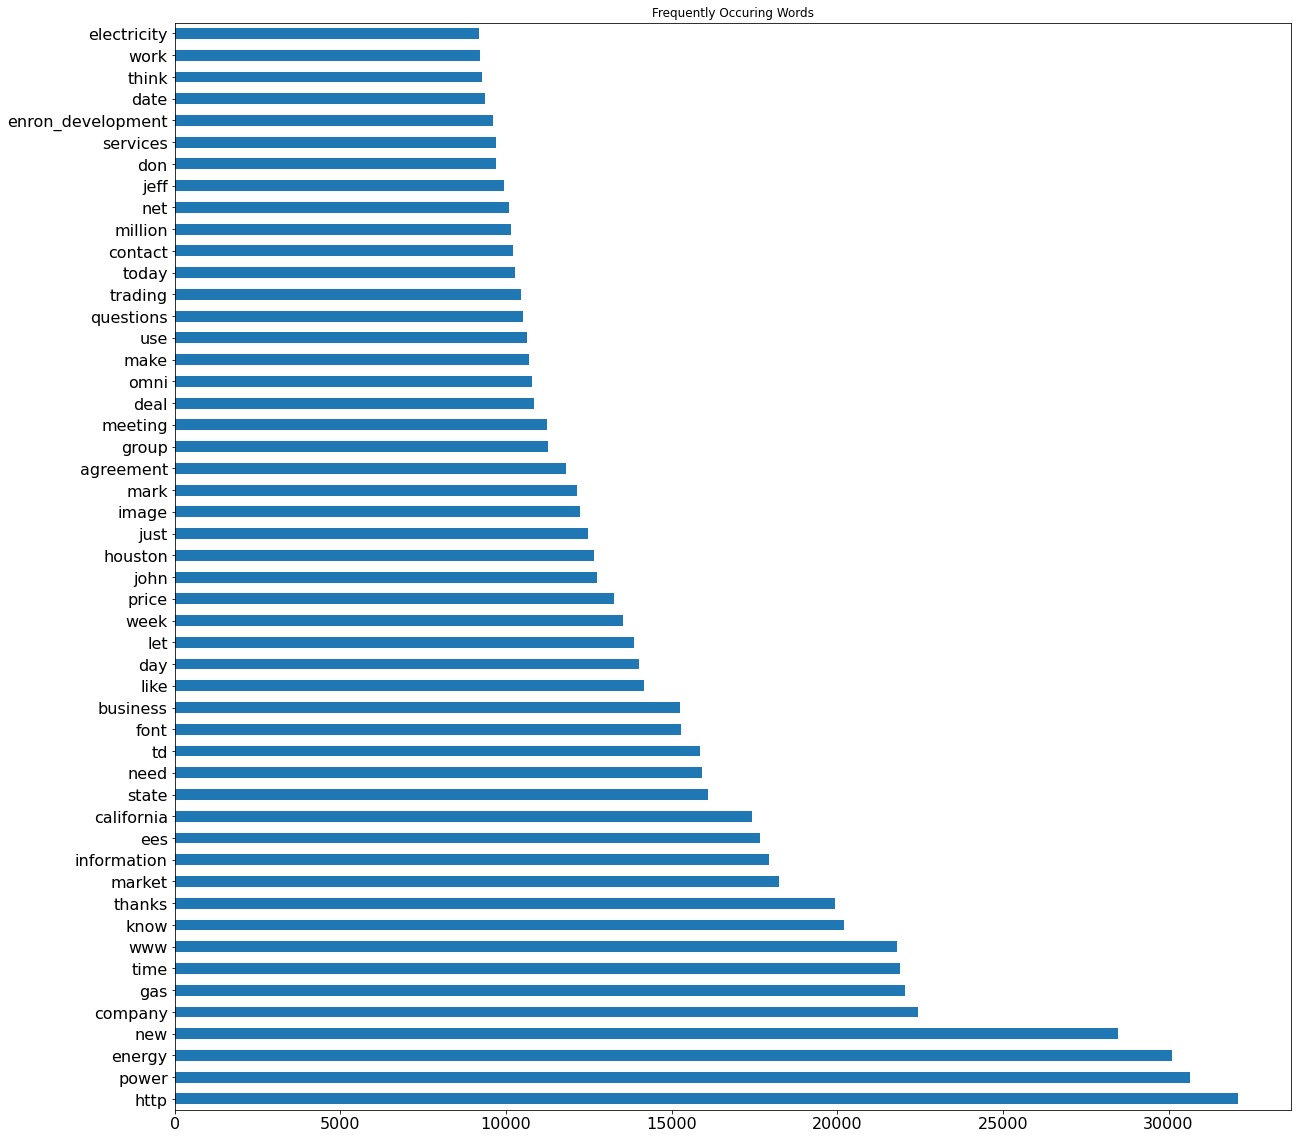

In [46]:
X_df.sum().sort_values(ascending=False).head(50).plot(kind='barh', figsize=(20,20), fontsize=16, title='Frequently Occuring Words');

In [47]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = cv.get_feature_names()

C:\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [48]:
for i in range(true_k):
     print('Cluster d:', i),
     for ind in order_centroids[i, :20]:
         print(' ', terms[ind])

Cluster d: 0
  friend
  management
  delainey
  opportunities
  txt
  statements
  stacey
  immediately
  europe
  david
  gov
  busypriority
  mailto
  knowledge
  international
  investor
  commissioner
  assets
  hit
  futures
Cluster d: 1
  mexico
  bpa
  ne
  outstanding
  identify
  minutes
  talked
  moore
  months
  monday
  missing
  mkt_type
  mind
  miller
  mike
  michelle
  michael
  marie
  miles
  period
Cluster d: 2
  southern
  energy
  2ecom
  bob
  role
  questions
  southwest
  approach
  stocks
  services
  sara
  friend
  donna
  65
  fixed
  sce
  free
  planned
  drew
  lon
Cluster d: 3
  opportunities
  delainey
  sector
  attend
  busypriority
  dear
  europe
  knowledge
  ancillary
  management
  limited
  package
  commission
  pacific
  busyname
  assets
  home
  offers
  critical
  change
Cluster d: 4
  love
  energy
  southern
  approach
  friend
  txt
  stocks
  role
  responsibility
  65
  red
  sara
  free
  progress
  begin
  brent
  skilling
  applic